In [122]:
import nltk
from nltk import word_tokenize
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

In [123]:
# load the data
df_true = pd.read_csv("data/True.csv")
df_fake = pd.read_csv("data/Fake.csv")

In [124]:
# add a target class column to indicate whether the news is real or fake
df_true['isfake'] = 1
df_true.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [125]:
df_fake['isfake'] = 0
df_fake.head()

,title,text,subject,date,isfake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [126]:
# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [127]:
# drpo unnecessary Date column # RUN ONLY ONCE
df.drop(columns = ['date'], inplace = True)
df.drop(columns = ['subject'], inplace = True)

In [128]:
# combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1,Trump wants Postal Service to charge 'much mor...


In [129]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use']) # add additional stop words to remove

In [130]:
# Remove stopwords and remove words with 2 or less characters using gensim
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [131]:
# Apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

In [132]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)


In [133]:
# Obtain the total number of unique words (using set())
total_words = len(list(set(list_of_words)))
total_words

108704

In [134]:
# join the words into a string (words seperated by " ")
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [135]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [136]:
# split data into test and train 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [137]:
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [138]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


In [139]:
len(train_sequences[0])

437

In [140]:
len(test_sequences)

8980

In [141]:
print("The encoding for document\n",x_train[0],"\n is : ",train_sequences[0])

The encoding for document
 obama praises argentina hurry macri reforms buenos aires reuters president barack obama wednesday championed argentina center right leader mauricio macri example countries latin america praising fast pace reforms strengthen economy obama visit argentina marks detente years tensions said argentina macri poised play influential role global stage days office macri distanced south america leftist bloc allies president cristina fernandez sought thaw relations western capitals seeks investment latin america economy tell president macri hurry obama told joint news conference leaders held talks impressed moved rapidly reforms promised create sustainable inclusive economic growth reconnect argentina global economy world community said macri offers obama ally south america region strong leftist bloc turned washington past decade public opinion shifting political center governments grapple graft scandals economic slowdown argentina assuming traditional leadership role r

In [142]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
# Make sure all different samples have the same length (fillted 0 s for missing)
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [143]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128))) # no of neurons

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid')) # reason: we do binary classification here
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         13914112  
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,210,305
Trainable params: 14,210,305
Non-trainable params: 0
_________________________________________________________________


In [144]:
total_words

108704

In [145]:
y_train = np.asarray(y_train)

In [146]:
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 3)

Epoch 1/3
506/506 [==============================] - 82s 156ms/step - loss: 0.0375 - acc: 0.9849 - val_loss: 0.0047 - val_acc: 0.9989
Epoch 2/3
506/506 [==============================] - 81s 159ms/step - loss: 0.0031 - acc: 0.9992 - val_loss: 0.0053 - val_acc: 0.9986
Epoch 3/3
506/506 [==============================] - 84s 166ms/step - loss: 8.9247e-04 - acc: 0.9996 - val_loss: 0.0186 - val_acc: 0.9981


In [147]:
model.save("mymodel.h5")

In [148]:
# make prediction
pred = model.predict(padded_test)

281/281 [==============================] - 3s 10ms/step


In [149]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [150]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)
accuracy = round(accuracy * 100, 2)
print("Model Accuracy : ", accuracy)

Model Accuracy :  99.82


<AxesSubplot:>

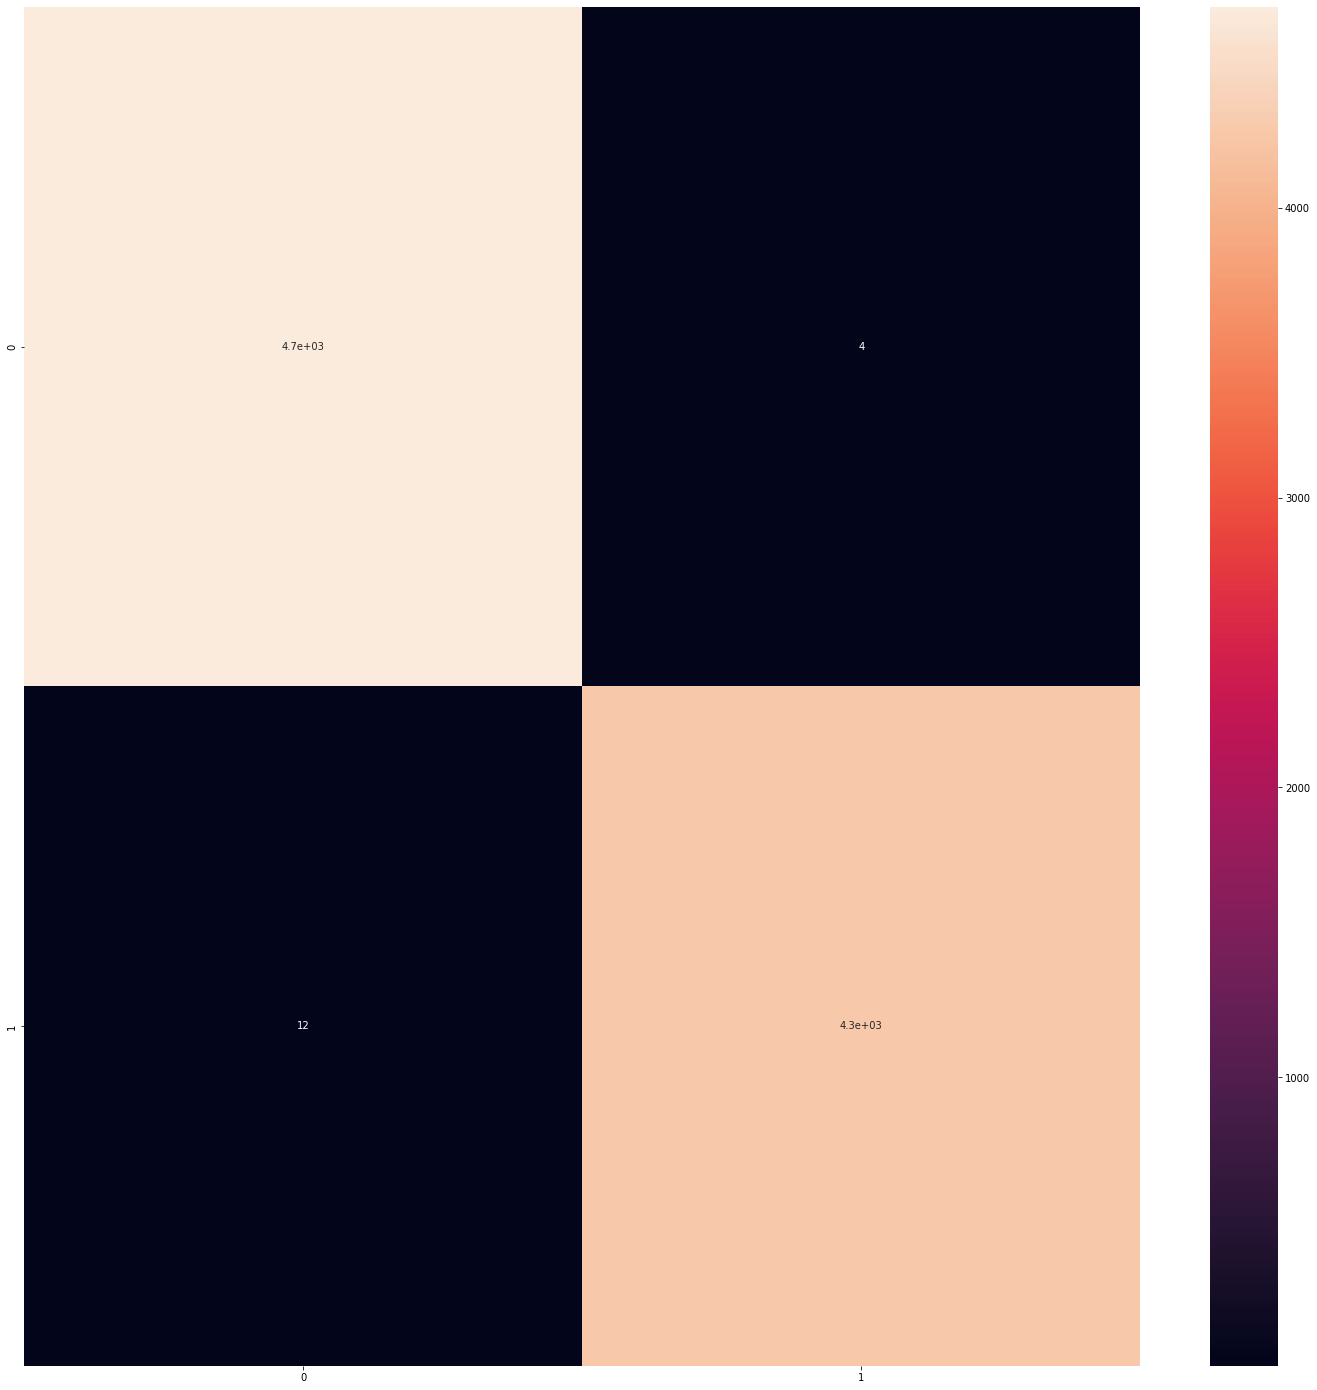

In [151]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

In [152]:
# category dict
category = { 0: 'Fake News', 1 : "Real News"}

In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfvect = TfidfVectorizer(stop_words='english',max_df=0.7)
tfid_x_train = tfvect.fit_transform(x_train)
tfid_x_test = tfvect.transform(x_test)

In [154]:
from sklearn.linear_model import PassiveAggressiveClassifier

pac_classifier = PassiveAggressiveClassifier()
pac_classifier.fit(tfid_x_train,y_train)
y_pred = pac_classifier.predict(tfid_x_test)
score = accuracy_score(y_test,y_pred)
pac_score = round(score*100,2)
print(f'Accuracy: {pac_score}%')

Accuracy: 99.45%


In [155]:
from sklearn.naive_bayes import MultinomialNB 
nb_classifier = MultinomialNB()
nb_classifier.fit(tfid_x_train,y_train)
y_pred = nb_classifier.predict(tfid_x_test)
score = accuracy_score(y_test,y_pred)
nb_score = round(score*100,2)
print(f'Accuracy: {nb_score}%')

Accuracy: 93.83%


In [156]:
from sklearn.neighbors import KNeighborsClassifier
knc_classifier=KNeighborsClassifier()
knc_classifier.fit(tfid_x_train,y_train)
y_pred = knc_classifier.predict(tfid_x_test)
score = accuracy_score(y_test,y_pred)
knc_score = round(score*100,2)
print(f'Accuracy: {knc_score}%')

Accuracy: 86.45%


In [157]:
from sklearn.linear_model import LogisticRegression
lr_classifier=LogisticRegression()
lr_classifier.fit(tfid_x_train,y_train)
y_pred = lr_classifier.predict(tfid_x_test)
score = accuracy_score(y_test,y_pred)
lr_score = round(score*100,2)
print(f'Accuracy: {lr_score}%')

Accuracy: 98.61%


In [158]:
from sklearn.tree import DecisionTreeClassifier
dtc_classifier=DecisionTreeClassifier()
dtc_classifier.fit(tfid_x_train,y_train)
y_pred = dtc_classifier.predict(tfid_x_test)
score = accuracy_score(y_test,y_pred)
dtc_score = round(score*100,2)
print(f'Accuracy: {dtc_score}%')

Accuracy: 99.69%


In [159]:
from sklearn.ensemble import RandomForestClassifier
rfc_classifier=RandomForestClassifier()
rfc_classifier.fit(tfid_x_train,y_train)
y_pred = rfc_classifier.predict(tfid_x_test)
score = accuracy_score(y_test,y_pred)
rfc_score = round(score*100,2)
print(f'Accuracy: {rfc_score}%')

Accuracy: 99.15%


In [160]:
import matplotlib.pyplot as plt
import numpy as np
x = ["LTSM","Decision Tree", "Passive Aggressive", "Random Forest", "Logistic Regression", "NaiveBayes",  "k-neighbours"]
y = [accuracy, dtc_score, pac_score, rfc_score, lr_score, nb_score, knc_score]

In [161]:
y

[99.82, 99.69, 99.45, 99.15, 98.61, 93.83, 86.45]

In [162]:
from colour import Color
green = Color("green")
colors = list(green.range_to(Color("red"),7))
colors = [color.rgb for color in colors]

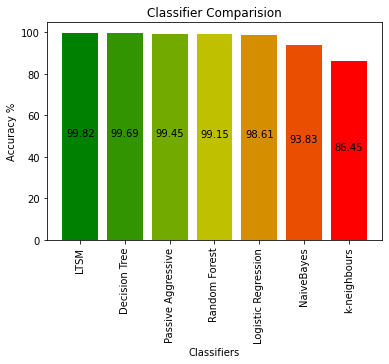

In [163]:
def add_value_label(x_list,y_list):
    for i in range(len(x)):
        plt.text(i,y[i]/2,y[i],  ha="center")

plt.bar(x, y, color=colors)
plt.xlabel('Classifiers')
plt.ylabel("Accuracy %")
plt.title('Classifier Comparision')
plt.xticks(rotation='vertical')
add_value_label(x,y)


        
plt.show()

In [164]:
def fake_news_det(news):    
    inp = []
    inp.insert(0,news)

    processed_inp = preprocess(inp[0])
    joined_inp = ' '.join(processed_inp)
    list_inp = []
    list_inp.append(joined_inp)

    inp_seq = tokenizer.texts_to_sequences(list_inp)

    pad_inp = pad_sequences(inp_seq,maxlen = 30, truncating = 'post') 

    op = model.predict(pad_inp)

#     print(op)

# if the predicted value is >0.5 it is real else it is fake
    prediction = []
    if op > 0.5:
        prediction = "REAL"
    else:
        prediction = "FAKE"
    print(prediction)


In [165]:
fake_news_det('Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.')

1/1 [==============================] - 1s 535ms/step
FAKE


In [166]:
fake_news_det('WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trumpâ€™s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administrationâ€™s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. â€œThe Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DODâ€™s study and will continue to defend the presidentâ€™s lawful authority in District Court in the meantime,â€ the official said, speaking on condition of anonymity. In September, the Pentagon said it had created a panel of senior officials to study how to implement a directive by Trump to prohibit transgender individuals from serving. The Defense Department has until Feb. 21 to submit a plan to Trump. Lawyers representing currently-serving transgender service members and aspiring recruits said they had expected the administration to appeal the rulings to the conservative-majority Supreme Court, but were hoping that would not happen. Pentagon spokeswoman Heather Babb said in a statement: â€œAs mandated by court order, the Department of Defense is prepared to begin accessing transgender applicants for military service Jan. 1. All applicants must meet all accession standards.â€ Jennifer Levi, a lawyer with gay, lesbian and transgender advocacy group GLAD, called the decision not to appeal â€œgreat news.â€ â€œIâ€™m hoping it means the government has come to see that there is no way to justify a ban and that itâ€™s not good for the military or our country,â€ Levi said. Both GLAD and the American Civil Liberties Union represent plaintiffs in the lawsuits filed against the administration. In a move that appealed to his hard-line conservative supporters, Trump announced in July that he would prohibit transgender people from serving in the military, reversing Democratic President Barack Obamaâ€™s policy of accepting them. Trump said on Twitter at the time that the military â€œcannot be burdened with the tremendous medical costs and disruption that transgender in the military would entail.â€ Four federal judges - in Baltimore, Washington, D.C., Seattle and Riverside, California - have issued rulings blocking Trumpâ€™s ban while legal challenges to the Republican presidentâ€™s policy proceed. The judges said the ban would likely violate the right under the U.S. Constitution to equal protection under the law. The Pentagon on Dec. 8 issued guidelines to recruitment personnel in order to enlist transgender applicants by Jan. 1. The memo outlined medical requirements and specified how the applicantsâ€™ sex would be identified and even which undergarments they would wear. The Trump administration previously said in legal papers that the armed forces were not prepared to train thousands of personnel on the medical standards needed to process transgender applicants and might have to accept â€œsome individuals who are not medically fit for service.â€ The Obama administration had set a deadline of July 1, 2017, to begin accepting transgender recruits. But Trumpâ€™s defense secretary, James Mattis, postponed that date to Jan. 1, 2018, which the presidentâ€™s ban then put off indefinitely. Trump has taken other steps aimed at rolling back transgender rights. In October, his administration said a federal law banning gender-based workplace discrimination does not protect transgender employees, reversing another Obama-era position. In February, Trump rescinded guidance issued by the Obama administration saying that public schools should allow transgender students to use the restroom that corresponds to their gender identity. ')

1/1 [==============================] - 0s 19ms/step
FAKE


In [167]:
df.to_csv('news.csv')